In [ ]:
"""
Example usage of chemrxn-cleaner on ORD data aggregated from a local dataset directory.

Source: https://github.com/open-reaction-database/ord-data/tree/main/data

"""
from rdkit import RDLogger

# Disable all RDKit logs
RDLogger.DisableLog('rdApp.*')

from __future__ import annotations

import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import List

from chemrxn_cleaner import clean_reactions
from chemrxn_cleaner import max_smiles_length
from chemrxn_cleaner import load_reactions
from chemrxn_cleaner import ReactionRecord
from chemrxn_cleaner import similarity_filter
from chemrxn_cleaner import export_reaction_records_to_json


DATA_ROOT = Path("/home/pyl/datasets/ord-data/data")


def get_ord_dataset_files(root: Path) -> List[Path]:
    ord_files: List[Path] = []
    for path in root.rglob("*"):
        if not path.is_file():
            continue
        suffix = "".join(path.suffixes).lower()
        if suffix.endswith(".pb") or suffix.endswith(".pb.gz"):
            ord_files.append(path)
    return sorted(ord_files)


dataset_files = get_ord_dataset_files(DATA_ROOT)
print(f"Found {len(dataset_files)} ORD dataset files under {DATA_ROOT}")
dataset_files = dataset_files[0:1]
def load_and_clean_ord_file(path: Path) -> List[ReactionRecord]:
    
    rxn_ord = load_reactions(
        source=str(path),
        fmt="ord",
    )
    # read ORD (Open Reaction Database) data from your local environment
    TEST = "Cn2cc(c1ccccc1)nn2"
    return clean_reactions(rxn_smiles_list=rxn_ord, filters=[
        max_smiles_length(500),
        similarity_filter(query_smiles=TEST, role='any', threshold=0.2)
    ])


rxn_processed: List[ReactionRecord] = []

if dataset_files:
    cpu_workers = os.cpu_count() or 4
    max_workers = max(1, min(len(dataset_files), cpu_workers * 2))
    print(f"Loading data with up to {max_workers} threads...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(load_and_clean_ord_file, path): path for path in dataset_files}
        for future in as_completed(futures):
            path = futures[future]
            try:
                reactions = future.result()
            except Exception as exc:
                print(f"Failed to load {path}: {exc}")
                continue
            # Load each ORD file concurrently to keep pace with the large dataset.
            rxn_processed.extend(reactions)
else:
    print(f"No ORD dataset files found in {DATA_ROOT}")

print(f"Total ORD reactions processed after the filter: {len(rxn_processed)}")

export_reaction_records_to_json(records=rxn_processed, path='./export.json')





In [ ]:
"""
Example usage of chemrxn-cleaner on uspto data aggregated from a local dataset directory.

Source: https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873

"""
from __future__ import annotations
from rdkit import RDLogger

# Disable all RDKit logs
RDLogger.DisableLog('rdApp.*')

from chemrxn_cleaner import clean_reactions
from chemrxn_cleaner import load_reactions

USPTO_SOURCE = "/home/pyl/datasets/uspto/1976_Sep2016_USPTOgrants_smiles.rsmi"

rxn_list = load_reactions(
    source=USPTO_SOURCE,
    fmt="uspto",
    keep_meta=True,
)
print(f"Loaded {len(rxn_list)} raw reactions from {USPTO_SOURCE}")

rxn_filtered = clean_reactions(rxn_smiles_list=rxn_list)




In [ ]:
"""
Example usage of chemrxn-cleaner on json data aggregated from a local dataset directory.

Source data: https://github.com/msaebi1993/yield-rxn/tree/master/data/dy/raw

"""
from typing import Any, Dict

from chemrxn_cleaner import ReactionRecord
from chemrxn_cleaner.parser import parse_reaction_smiles
from chemrxn_cleaner import load_reactions

SOURCE_PATH = "/home/pyl/datasets/json-data/yield-rxn/data/dy/raw/dy_reactions_data.json"

def to_reaction_record(entry: Dict[str, Any]) -> ReactionRecord:
    """Map raw JSON dicts into ReactionRecord instances."""
    if "reaction_smiles" in entry:
        rec = ReactionRecord.from_dict(entry)
    else:
        reactants = [str(s['smiles']) for s in entry.get("reactants", [])]
        reagents = [entry['base']['smiles']]
        products = [entry['product']['smiles']]
        rxn_smiles = ">".join([".".join(reactants), ".".join(reagents), ".".join(products)])
        rec = parse_reaction_smiles(rxn_smiles, strict=False)
        rec.reactants = reactants
        rec.reagents = reagents
        rec.products = products
        rec.bases = reagents
    rec.source = entry.get("source", "json") or "json"
    rec.reaction_id = entry.get("reaction_id", entry.get("id", ""))
    rec.extra_metadata.update(entry.get("meta", {}))
    return rec


rxn_records = load_reactions(source=SOURCE_PATH, fmt='json', mapper=to_reaction_record)
print(f"Parsed {len(rxn_records)} ReactionRecord objects")
print(rxn_records[0].to_dict())
rxn_records[0].show()


Parsed 2003 ReactionRecord objects from NiCOlit
{'reaction_id': 'https://doi.org/10.1002/chem.201603436', 'source': 'NiCOlit', 'source_ref': 'https://doi.org/10.1002/chem.201603436', 'source_file_path': '/home/pyl/datasets/csv-data/NiCOlit/data/NiCOlit.csv', 'reaction_smiles': 'COc1ccc2ccccc2c1.[Li]c1ccccc1>>c3ccc(c2ccc1ccccc1c2)cc3', 'reactants': ['COc1ccc2ccccc2c1', '[Li]c1ccccc1'], 'reagents': [], 'products': ['c3ccc(c2ccc1ccccc1c2)cc3'], 'atom_mapping': None, 'reaction_class': None, 'procedure': {}, 'temperature_c': None, 'time_hours': None, 'pressure_bar': None, 'ph': None, 'solvents': ['toluene'], 'catalysts': ['Ni(cod)2'], 'bases': [], 'additives': [], 'atmosphere': None, 'scale_mmol': None, 'yield_value': 73.0, 'yield_type': 'none', 'success': None, 'selectivity': None, 'selectivity_type': None, 'is_balanced': None, 'sanity_check_passed': True, 'warnings': [], 'split': None, 'extra_numeric': {}, 'extra_categorical': {}, 'extra_metadata': {'origin': 'Optimisation', 'mechanism': 

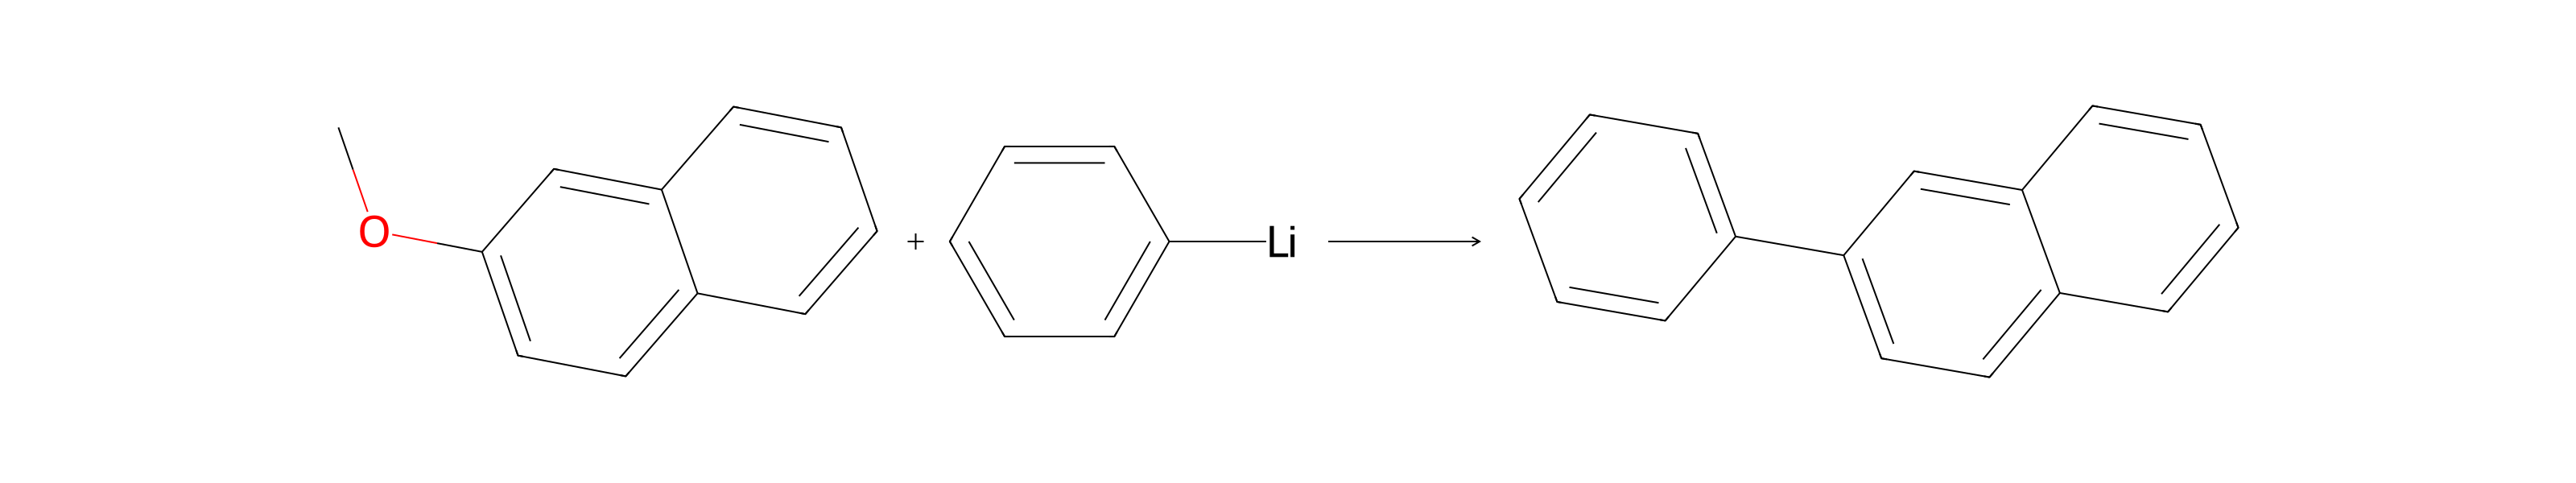

origin,Optimisation
mechanism,Murahashi
review,Research_Article
scheme_table,Table 1


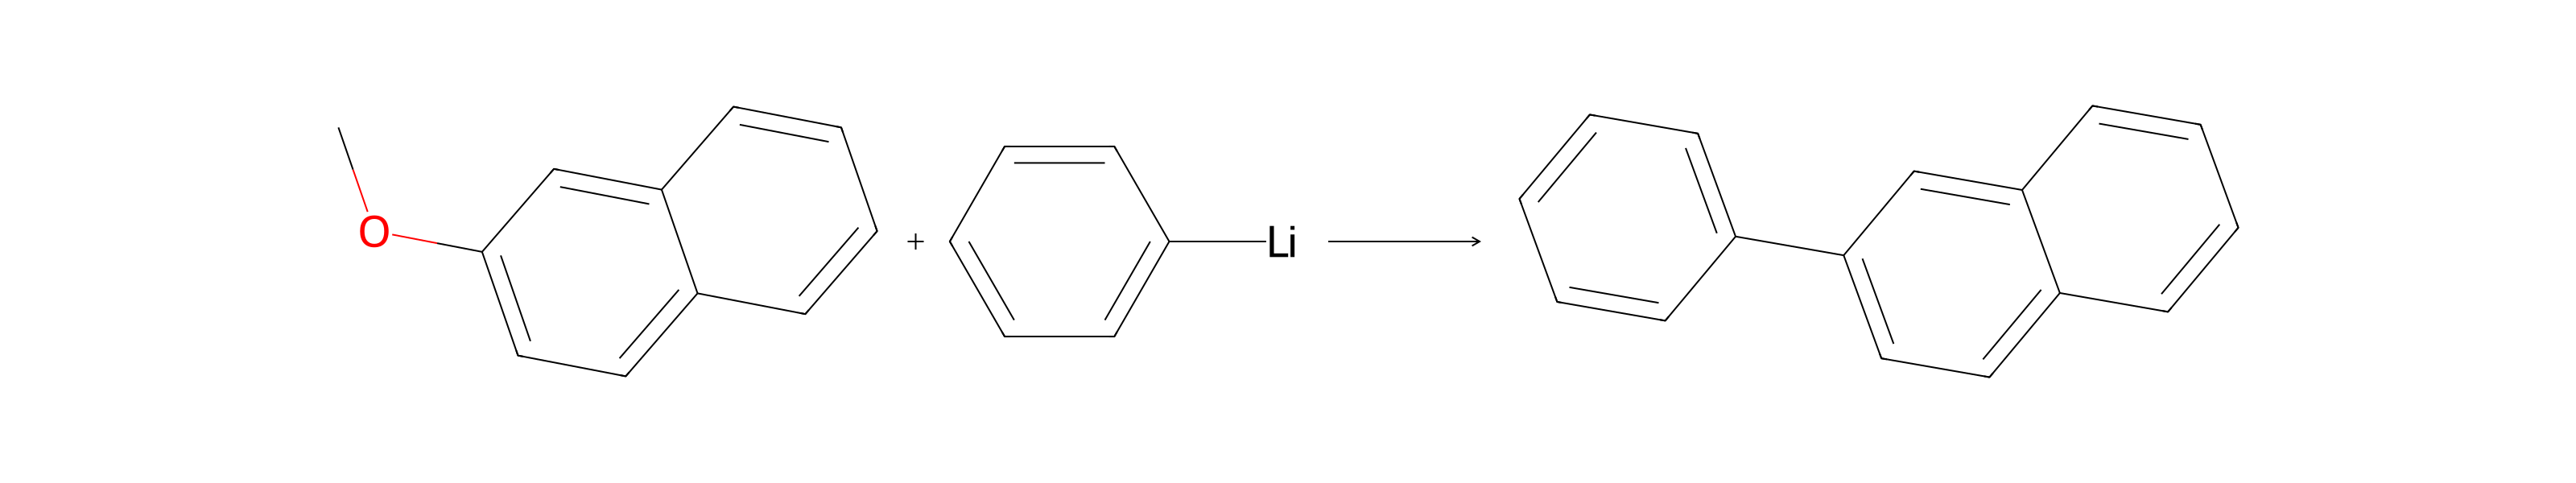

In [2]:
"""
Example usage of chemrxn-cleaner on csv data aggregated from a local dataset directory.

Source data: https://github.com/truejulosdu13/NiCOlit/blob/master/data/NiCOlit.csv

"""
from typing import Any, Dict, Optional

from chemrxn_cleaner import ReactionRecord
from chemrxn_cleaner import load_reactions

SOURCE_PATH = "/home/pyl/datasets/csv-data/NiCOlit/data/NiCOlit.csv"


def _to_float(value: Any) -> Optional[float]:
    try:
        text = str(value).replace("%", "").strip()
        if not text:
            return None
        return float(text)
    except Exception:
        return None


def map_row(record: ReactionRecord, row: Dict[str, Any]) -> ReactionRecord:
    record.source = "NiCOlit"
    record.source_ref = row.get("DOI") or None
    record.reaction_id = row.get("DOI", "")
    record.solvents = [row["solvent"]] if row.get("solvent") else []
    record.catalysts = [row["catalyst_precursor"]] if row.get("catalyst_precursor") else []
    record.yield_value = _to_float(row.get("isolated_yield")) or _to_float(
        row.get("analytical_yield")
    )
    # retain a few useful metadata fields
    record.extra_metadata.update(
        {
            "origin": row.get("origin"),
            "mechanism": row.get("Mechanism"),
            "review": row.get("review"),
            "scheme_table": row.get("scheme_table"),
        }
    )
    return record


rxn_records = load_reactions(
    source=SOURCE_PATH,
    fmt="csv",
    reactant_columns=["substrate", "effective_coupling_partner"],
    reagent_columns=[],
    product_columns=["product"],
    mapper=map_row,
)
print(f"Parsed {len(rxn_records)} ReactionRecord objects from NiCOlit")
print(rxn_records[0].to_dict())
rxn_records[0].show()
